# 三步设计量化交易策略
一、 数据读取与处理

二、 算法与画图观察

三、 思考与构思进场条件

## 一、数据读取与处理
1. 安装Mongodb
2. 安装Robomongo
3. 一键导入期货分钟数据
4. 安装pymongo
5. 安装datautils
6. 数据库数据读取
7. 数据合并处理

1. 安装Mongodb: https://www.mongodb.com/download-center/community
2. 安装Robomongo: http://mongodb-tools.com/tool/robomongo/
3. 一键导入期货分钟数据：https://share.weiyun.com/5do1N9W

测试： 检阅robomongo是否有数据

4. 安装pymongo：pip install pymongo
5. 安装datautils：pip install git+https://github.com/cheatm/datautils.git

6. 数据库数据读取
    1. import
    2. Client
    3. DataBase
    4. Collections

In [1]:
# import Mongodb相应工具
from pymongo import MongoClient
from datautils.mongodb import read

In [4]:
from datetime import datetime
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
client = MongoClient()
IF88 = read(client['VnTrader_1Min_Db']['IF88:CTP'],datetime=(datetime(2018,1,1), datetime(2019,3,21))).set_index('datetime')

In [7]:
IF88.tail()

,close,date,exchange,high,low,open,openInterest,symbol,time,trading_date,volume,vtSymbol
datetime,,,,,,,,,,,,
2019-03-20 14:55:00,3836.2,20190320,CTP,3839.6,3835.0,3839.4,67597,IF88,14:55:00,2019-03-20,406,IF88:CTP
2019-03-20 14:56:00,3836.2,20190320,CTP,3836.4,3834.6,3836.0,67726,IF88,14:56:00,2019-03-20,352,IF88:CTP
2019-03-20 14:57:00,3835.6,20190320,CTP,3838.4,3835.2,3836.0,67854,IF88,14:57:00,2019-03-20,326,IF88:CTP
2019-03-20 14:58:00,3836.4,20190320,CTP,3836.8,3835.6,3835.6,68074,IF88,14:58:00,2019-03-20,368,IF88:CTP
2019-03-20 14:59:00,3837.4,20190320,CTP,3837.8,3836.0,3836.4,68327,IF88,14:59:00,2019-03-20,569,IF88:CTP


7. 数据合并处理
    1. resample
    2. agg

In [8]:
def resampleDf(data, freq='H'):
    return data.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})

In [9]:
dataResample = resampleDf(IF88, '15Min')

In [10]:
dataResample.tail()

,open,high,low,close,volume
datetime,,,,,
2019-03-20 13:45:00,3811.6,3812.2,3799.0,3802.6,3253.0
2019-03-20 14:00:00,3802.8,3830.6,3801.6,3828.2,6133.0
2019-03-20 14:15:00,3829.0,3847.6,3822.8,3846.0,5577.0
2019-03-20 14:30:00,3846.4,3848.2,3837.4,3839.0,3722.0
2019-03-20 14:45:00,3838.8,3844.4,3834.6,3837.4,4488.0


## 二、 算法与画图观察
1. 安装jaqs_fxdayu
2. 将数据库数据转换成jaqs需要的数据格式
3. 将数据导入HFDataView
4. 算法使用与画图观察
5. 因子算法案例
6. talib
7. 画图去除停牌时间

1. 安装jaqs_fxdayu: pip install git+https://github.com/xingetouzi/jaqs-fxdayu.git

2. 将数据库数据转换成jaqs需要的数据格式
    1. reset_index
    2. datetime to int
    3. add symbol column

In [14]:
# reset_index
# dataResample
def dt2int(t):
    return t.year*10**10+t.month*10**8+t.day*10**6+t.hour*10*4+t.minute*10**2+t.second

def modifyDf(data, symbol):
    assert isinstance(data, pd.DataFrame)
    data = data.reset_index()
    data['trade_date'] = data['datetime'].apply(dt2int)
    data['symbol'] = symbol
    return data

In [15]:
dataIf = modifyDf(dataResample, 'IF88:CTP')

In [16]:
dataIf.tail()

,datetime,open,high,low,close,volume,trade_date,symbol
42449,2019-03-20 13:45:00,3811.6,3812.2,3799.0,3802.6,3253.0,20190320005020,IF88:CTP
42450,2019-03-20 14:00:00,3802.8,3830.6,3801.6,3828.2,6133.0,20190320000560,IF88:CTP
42451,2019-03-20 14:15:00,3829.0,3847.6,3822.8,3846.0,5577.0,20190320002060,IF88:CTP
42452,2019-03-20 14:30:00,3846.4,3848.2,3837.4,3839.0,3722.0,20190320003560,IF88:CTP
42453,2019-03-20 14:45:00,3838.8,3844.4,3834.6,3837.4,4488.0,20190320005060,IF88:CTP


In [4]:
# datetime to int

In [5]:
# add symbol column

3. 将数据导入HFDataView
    1. import
    2. instantiation
    3. create_inti_dv

In [18]:
# import
from jaqs_fxdayu.data.hf_dataview import HFDataView

In [19]:
# instantiation
dv = HFDataView()

In [21]:
# create_inti_dv
dv.create_init_dv(dataIf.dropna().set_index(['trade_date', 'symbol']))

Initialize dataview success.


4. 算法使用与画图观察
    1. add_formula
    2. algorithm
    3. get_ts

In [22]:
# add_formula
gap = dv.add_formula('Gap','close-Delay(open, 1)', add_data=True)

In [23]:
# algorithm
gap.tail()

symbol,IF88:CTP
trade_date,
20190320003560,34.8
20190320004860,-11.8
20190320004900,22.8
20190320005020,-45.2
20190320005060,25.8


In [26]:
# get_ts
gapDt = dv.get_ts('Gap', date_type='datetime')

In [27]:
gapDt.tail()

symbol,IF88:CTP
trade_date,
2019-03-20 00:36:00,34.8
2019-03-20 00:49:00,-11.8
2019-03-20 00:49:00,22.8
2019-03-20 00:50:20,-45.2
2019-03-20 00:51:00,25.8


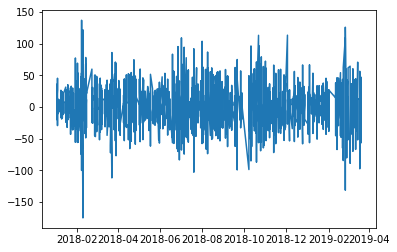

In [28]:
plt.plot(gapDt)
plt.show()

In [29]:
close = dv.get_ts('close', date_type='datetime')
alpha7=dv.add_formula('alpha007','If(Ts_Mean(volume, 20)<volume,((-1 * Ts_Rank(Abs(Delta(close, 7)), 60)) * Sign(Delta(close, 7))),-1)',add_data=True)
alpha007 = dv.get_ts('alpha007', date_type='datetime')

C:\Users\small\Anaconda3\lib\site-packages\jaqs\data\py_expression_eval.py:486: RuntimeWarning: invalid value encountered in less
  res = arr < brr
C:\Users\small\Anaconda3\lib\site-packages\jaqs_fxdayu\data\py_expression_eval.py:73: RuntimeWarning: invalid value encountered in sign
  nstack.append(_fillinf(f(n1)))


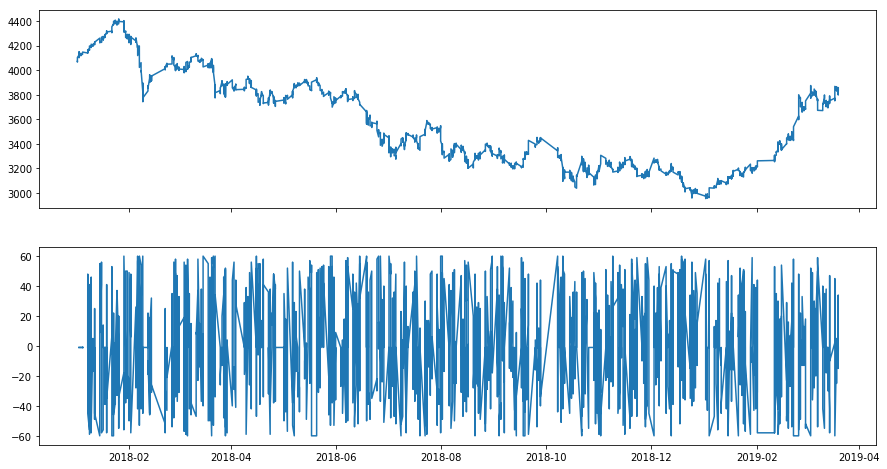

In [30]:
fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
ax.plot(close)
ax1.plot(alpha007)
plt.show()

6. talib

dv.add_formula('name', "Ta('Function',0,open, high, low, close, volume)",add_data=True)

In [42]:
macdDv = dv.add_formula('macd', "Ta('MACD',0,open, high, low, close, volume, 12, 26, 9)",add_data=True)
macdSignalDv = dv.add_formula('macdSignal', "Ta('MACD',1,open, high, low, close, volume, 12, 26, 9)",add_data=True)
macdHistDv = dv.add_formula('macdHist', "Ta('MACD',2,open, high, low, close, volume, 12, 26, 9)",add_data=True)

Field [macd] is overwritten.
Field [macdSignal] is overwritten.
Field [macdHist] is overwritten.


In [43]:
DataDf = pd.DataFrame(
                        {
                        'close':dv.get_ts('close', date_type = 'datetime')['IF88:CTP'],
                        'macd' : dv.get_ts('macd', date_type='datetime')['IF88:CTP'],
                        'macdSignal':dv.get_ts('macdSignal', date_type='datetime')['IF88:CTP'],
                        'macdHist':dv.get_ts('macdHist', date_type='datetime')['IF88:CTP']
                        }
                      )

In [44]:
def chartRange(df, n=100):
    fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(15,15))
    ax.plot(df.index[-n:], DataDf.close.iloc[-n:])
    ax1.plot(df.index[-n:], DataDf.macd.iloc[-n:])
    ax1.plot(df.index[-n:], DataDf.macdSignal.iloc[-n:])
    ax1.bar(df.index[-n:], DataDf.macdHist.iloc[-n:], color='green', width=0.8)
    plt.show()

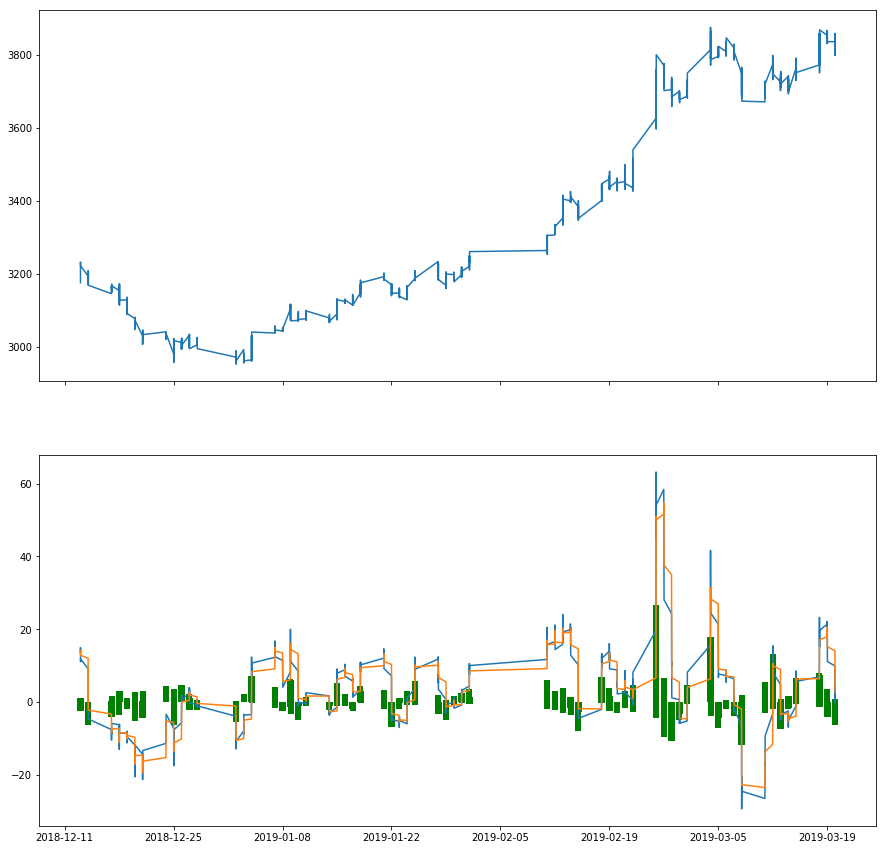

In [45]:
chartRange(DataDf, 1000)

7. 去除停盘时间
    1. reset_index
    2. strftime时间格式转成字符串
    3. xticks设置x轴索引

In [46]:
dataIf1 = DataDf.reset_index()

In [53]:
# strftime时间格式转成字符串
dataIf1['tradeDateStr'] = list(map(lambda x: x.strftime(format='%Y-%m-%d %H:%M:%S'), list(dataIf1.trade_date)))

In [54]:
dataIf1.tail()

,trade_date,close,macd,macdHist,macdSignal,tradeDateStr
4699,2019-03-20 00:36:00,3839.0,2.022678,-1.330135,3.352813,2019-03-20 00:36:00
4700,2019-03-20 00:49:00,3834.6,2.183255,-0.935647,3.118902,2019-03-20 00:49:00
4701,2019-03-20 00:49:00,3858.8,4.214667,0.876613,3.338055,2019-03-20 00:49:00
4702,2019-03-20 00:50:20,3802.6,1.275008,-1.650437,2.925445,2019-03-20 00:50:20
4703,2019-03-20 00:51:00,3837.4,1.733395,-0.953640,2.687035,2019-03-20 00:51:00


In [59]:
def chartRange(data, n=100):
    fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(15,15))
    ax.plot(data.index[-n:], data.close.iloc[-n:])
    ax1.plot(data.index[-n:], data.macd.iloc[-n:])
    ax1.plot(data.index[-n:], data.macdSignal.iloc[-n:])
    ax1.bar(data.index[-n:], data.macdHist.iloc[-n:], color='green', width=0.8)
    plt.xticks([data.index[-n:][0], data.index[-n:][int(n/2)], data.index[-n:][-1]],
               [data.tradeDateStr.iloc[0],data.tradeDateStr.iloc[int(n/2)], data.tradeDateStr.iloc[-1]])
    plt.show()

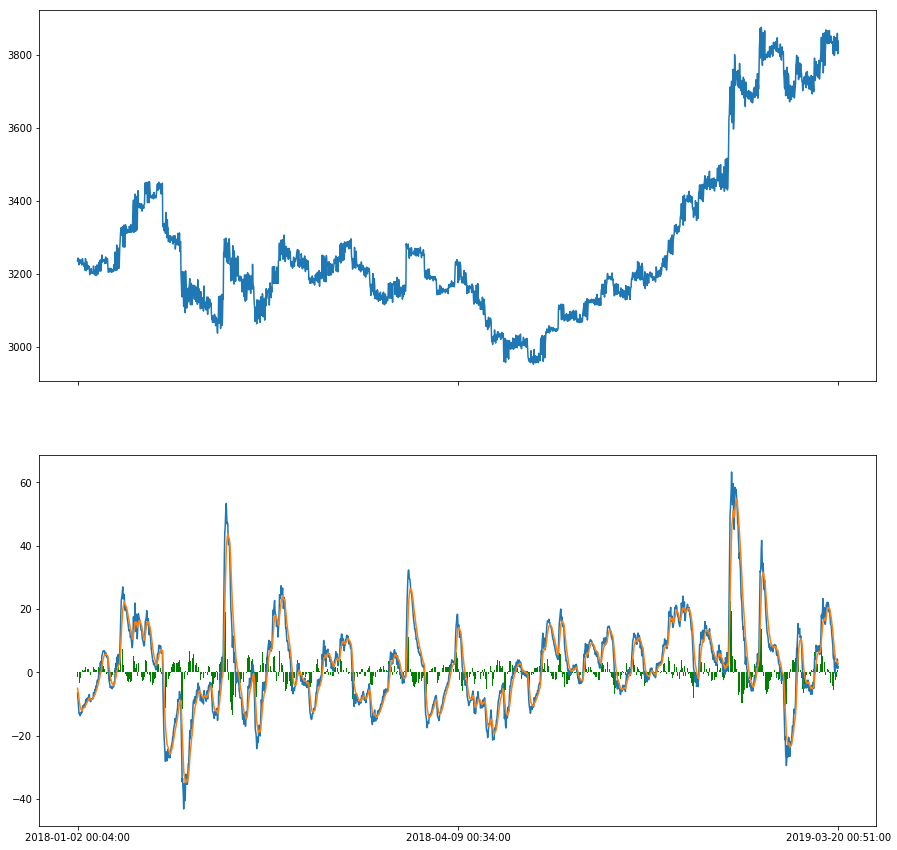

In [60]:
chartRange(dataIf1, n=2000)

## 设计算法策略
1. 0轴区分
2. 金叉死叉
3. 二次金叉与死叉
4. macd与macdSignal同涨同跌
5. macdHist的下降与上升
6. macdHist第五元素